In [1]:
#loading packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import joblib
sns.set()

In [2]:
# display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
#pip install bayesian-optimization

In [4]:
from bayes_opt import BayesianOptimization

# Libraries for Deep Learning Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# needed for `HistGradientBoostingClassifier`
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


# **Data loading**

In [5]:
#Fetching Bitcoin data price from Yahoo Finance for the last five years.
import yfinance as yf
# Setting the ticker as 'BTC-USD'
BTC_Ticker = yf.Ticker("BTC-USD")
BTC_Data = BTC_Ticker.history(period="5y")

In [6]:
# Getting the first 5 rows of our dataset
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-16 00:00:00+00:00,15955.577148,16816.181641,15880.706055,16716.111328,31526766675,0.0,0.0
2020-11-17 00:00:00+00:00,16685.691406,17782.919922,16564.544922,17645.406250,39006849170,0.0,0.0
2020-11-18 00:00:00+00:00,17645.191406,18393.949219,17352.906250,17804.005859,49064800278,0.0,0.0
2020-11-19 00:00:00+00:00,17803.861328,18119.546875,17382.554688,17817.089844,36985055355,0.0,0.0
2020-11-20 00:00:00+00:00,17817.083984,18773.226562,17765.794922,18621.314453,36992873940,0.0,0.0


# **Exploratory Data Analysis**

In [7]:
print(BTC_Data.shape)

(1827, 7)


In [8]:
print(BTC_Data.dtypes)

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


In [9]:
# missing values
print(BTC_Data.isnull().sum())

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [10]:
Descriptive_Statistics = BTC_Data.describe()
Descriptive_Statistics = Descriptive_Statistics.style.background_gradient(cmap='Blues', low=0, high=0.6)
Descriptive_Statistics

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,52685.063176,53725.687224,51587.536049,52726.771324,36784248045.796387,0.000000,0.000000
std,29390.990251,29797.348087,28954.737733,29396.131390,22596221283.897793,0.000000,0.000000
min,15782.300781,16253.047852,15599.046875,15787.284180,5331172801.000000,0.000000,0.000000
25%,28361.827148,28885.154297,27876.905273,28385.922852,21425516024.500000,0.000000,0.000000
50%,43998.464844,44793.601562,43109.339844,43997.902344,31744259539.000000,0.000000,0.000000
75%,66988.406250,68157.625000,65643.113281,67027.902344,46301313165.500000,0.000000,0.000000
max,124752.140625,126198.070312,123196.046875,124752.531250,350967941479.000000,0.000000,0.000000


# **Time Series Plot**

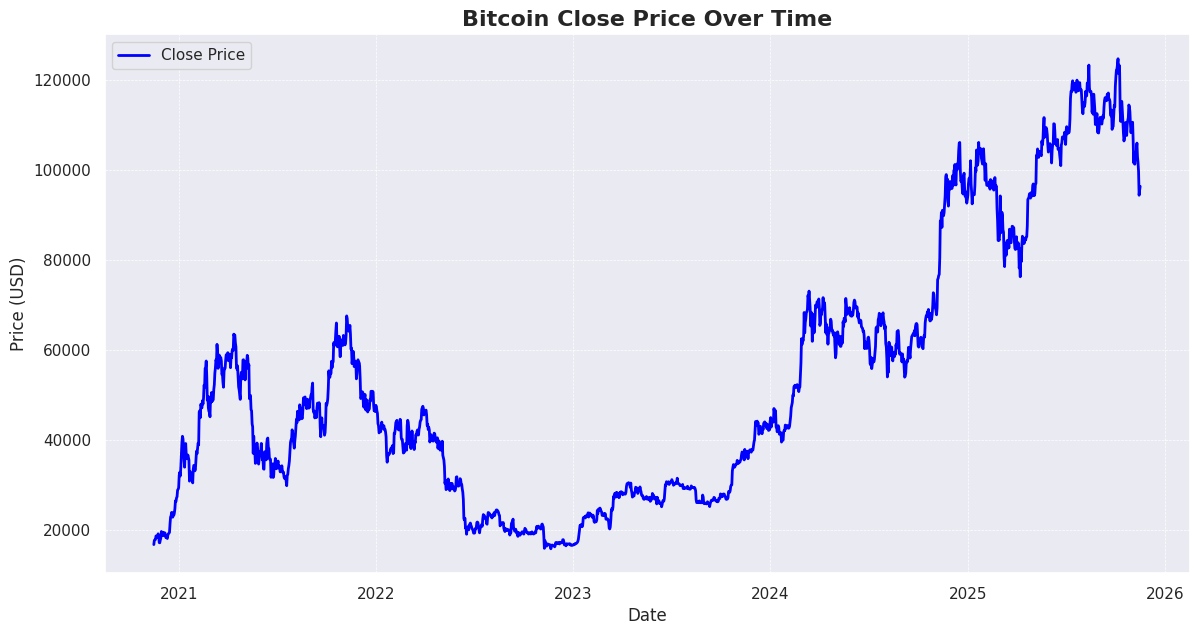

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(BTC_Data['Close'], label='Close Price', color='blue', linewidth=2)
plt.title('Bitcoin Close Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

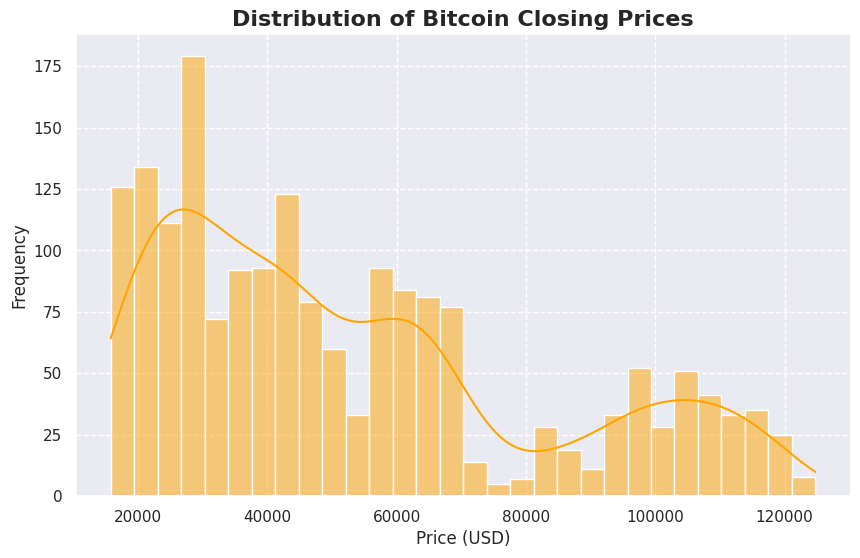

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(BTC_Data['Close'], bins=30, kde=True, color='orange')
plt.title('Distribution of Bitcoin Closing Prices', fontsize=16, fontweight='bold')
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(visible=True, linestyle='--')
plt.show()

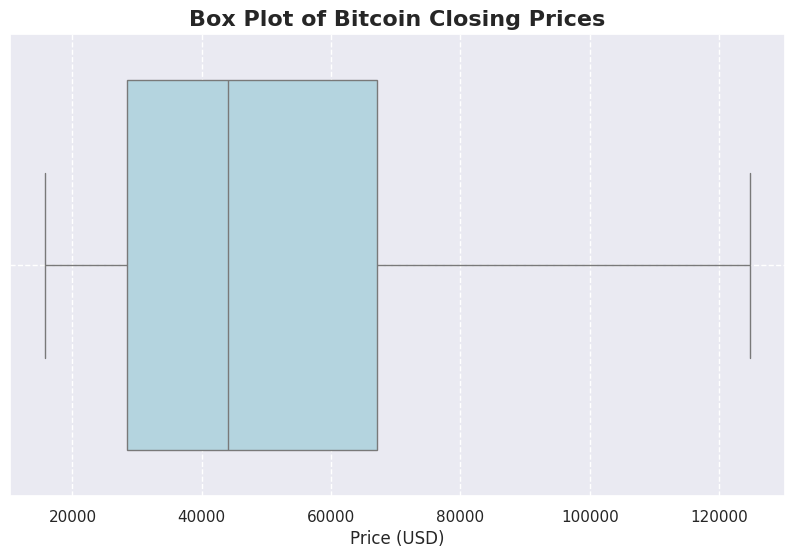

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=BTC_Data['Close'], color='lightblue')
plt.title('Box Plot of Bitcoin Closing Prices', fontsize=16, fontweight='bold')
plt.xlabel('Price (USD)', fontsize=12)
plt.grid(visible=True, linestyle='--')
plt.show()

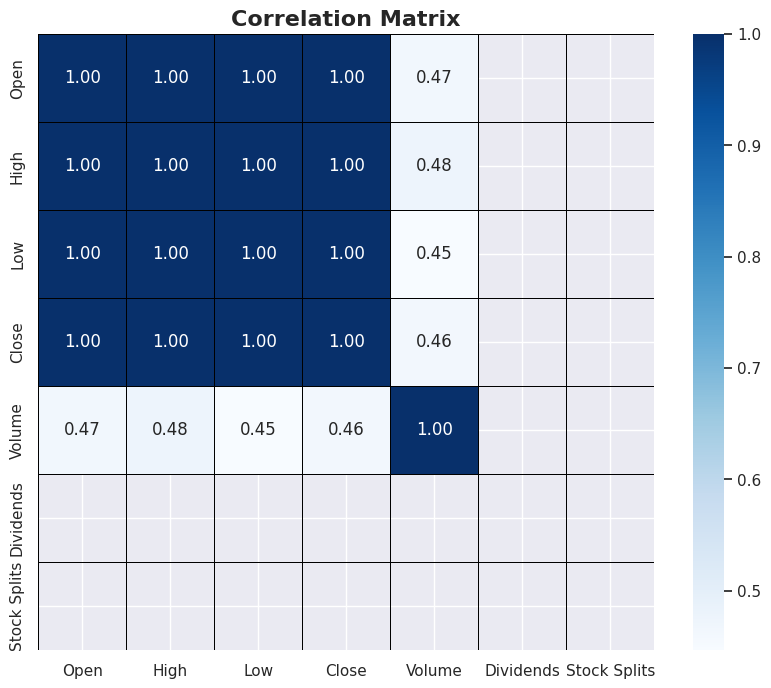

In [14]:
#correlation matrix
corr = BTC_Data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', square=True, linecolor='black', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

# **Data Preparation**

In [15]:
#creating our target variable, that is, the buy or sell signal

#short simple moving average over the short window
BTC_Data["short_moving_avg"] = (
    BTC_Data["Close"].rolling(window=10, min_periods=1, center=False).mean()
)

#long simple moving average over the long window
BTC_Data["long_maving_avg"] = (
    BTC_Data["Close"].rolling(window=60, min_periods=1, center=False).mean()
)

#signals
BTC_Data["signal"] = np.where(
    BTC_Data["short_moving_avg"] > BTC_Data["long_maving_avg"], 1.0, 0.0
)

In [16]:
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal
Date,,,,,,,,,,
2020-11-16 00:00:00+00:00,15955.577148,16816.181641,15880.706055,16716.111328,31526766675,0.0,0.0,16716.111328,16716.111328,0.0
2020-11-17 00:00:00+00:00,16685.691406,17782.919922,16564.544922,17645.406250,39006849170,0.0,0.0,17180.758789,17180.758789,0.0
2020-11-18 00:00:00+00:00,17645.191406,18393.949219,17352.906250,17804.005859,49064800278,0.0,0.0,17388.507812,17388.507812,0.0
2020-11-19 00:00:00+00:00,17803.861328,18119.546875,17382.554688,17817.089844,36985055355,0.0,0.0,17495.653320,17495.653320,0.0
2020-11-20 00:00:00+00:00,17817.083984,18773.226562,17765.794922,18621.314453,36992873940,0.0,0.0,17720.785547,17720.785547,0.0


# **Feature Engineering**

In [17]:
# Function for calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df["Close"].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
    return EMA


BTC_Data["EMA10"] = EMA(BTC_Data, 10)
BTC_Data["EMA30"] = EMA(BTC_Data, 30)
BTC_Data["EMA200"] = EMA(BTC_Data, 200)
BTC_Data.head()


# Function for calculation of rate of change
def RC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    RC = pd.Series(((M / N) * 100), name="RC_" + str(n))
    return RC


BTC_Data["RC10"] = RC(BTC_Data["Close"], 10)
BTC_Data["RC30"] = RC(BTC_Data["Close"], 30)


# Function for Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name="Momentum_" + str(n))
    return MOM


BTC_Data["MOM10"] = MOM(BTC_Data["Close"], 10)
BTC_Data["MOM30"] = MOM(BTC_Data["Close"], 30)


# Function for calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[: (period - 1)])
    d[d.index[period - 1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[: (period - 1)])
    rs = (
        u.ewm(com=period - 1, adjust=False).mean()
        / d.ewm(com=period - 1, adjust=False).mean()
    )
    return 100 - 100 / (1 + rs)


BTC_Data["RSI10"] = RSI(BTC_Data["Close"], 10)
BTC_Data["RSI30"] = RSI(BTC_Data["Close"], 30)
BTC_Data["RSI200"] = RSI(BTC_Data["Close"], 200)

# Function for calculation of stochastic oscillator.
def STOK(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    return STOK


def STOD(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    STOD = STOK.rolling(3).mean()
    return STOD


BTC_Data["%K10"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%D10"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%K30"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%D30"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%K200"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)
BTC_Data["%D200"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)

In [18]:
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-12 00:00:00+00:00,103011.437500,105297.234375,100836.617188,101663.187500,64347179408,0.0,0.0,103436.258594,112114.130599,0.0,104285.503244,107805.771723,107940.316479,-4.584185,-10.126955,-8976.437500,-13607.890625,37.739547,42.105643,50.541242,22.885359,37.861174,15.603293,26.516596,26.404034,32.071053
2025-11-13 00:00:00+00:00,101674.148438,104005.492188,97988.718750,99697.492188,101546815416,0.0,0.0,102751.255469,111852.294531,0.0,103451.319415,107282.656914,107858.298326,-1.863394,-10.006640,-6850.031250,-13421.171875,34.054321,40.621140,50.215042,18.102297,24.683510,9.345427,16.086536,20.507643,25.772694
2025-11-14 00:00:00+00:00,99694.703125,99804.429688,94000.734375,94397.789062,114346441890,0.0,0.0,102031.982031,111501.509766,0.0,101805.222988,106451.375117,107724.362909,-9.138396,-12.744944,-7192.734375,-16385.375000,26.347165,36.984358,49.351954,2.957021,14.648226,1.782706,8.910476,4.269162,17.060279
2025-11-15 00:00:00+00:00,94420.468750,96728.468750,94420.468750,95549.148438,38500716654,0.0,0.0,101197.713281,111146.609115,0.0,100667.754888,105748.005654,107603.216495,-5.678250,-10.255346,-8342.687500,-12636.890625,30.162456,38.227282,49.541316,11.531643,10.863654,6.952110,6.026748,7.735187,10.837331
2025-11-16 00:00:00+00:00,95548.828125,96372.890625,94930.757812,96372.890625,46783758336,0.0,0.0,100704.873438,110811.682161,0.0,99886.870476,105143.159523,107491.471957,-6.771164,-10.098461,-4928.398438,-10094.898438,32.924558,39.116078,49.676604,17.666372,10.718345,10.650569,6.461795,9.064614,7.022988


In [19]:
def MA(df, n):
    MA = pd.Series(df["Close"].rolling(n, min_periods=n).mean(), name="MA_" + str(n))
    return MA


BTC_Data["MA21"] = MA(BTC_Data, 10)
BTC_Data["MA63"] = MA(BTC_Data, 30)
BTC_Data["MA252"] = MA(BTC_Data, 200)
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-12 00:00:00+00:00,103011.437500,105297.234375,100836.617188,101663.187500,64347179408,0.0,0.0,103436.258594,112114.130599,0.0,104285.503244,107805.771723,107940.316479,-4.584185,-10.126955,-8976.437500,-13607.890625,37.739547,42.105643,50.541242,22.885359,37.861174,15.603293,26.516596,26.404034,32.071053,103436.258594,107948.386458,110440.062734
2025-11-13 00:00:00+00:00,101674.148438,104005.492188,97988.718750,99697.492188,101546815416,0.0,0.0,102751.255469,111852.294531,0.0,103451.319415,107282.656914,107858.298326,-1.863394,-10.006640,-6850.031250,-13421.171875,34.054321,40.621140,50.215042,18.102297,24.683510,9.345427,16.086536,20.507643,25.772694,102751.255469,107501.014063,110469.775977
2025-11-14 00:00:00+00:00,99694.703125,99804.429688,94000.734375,94397.789062,114346441890,0.0,0.0,102031.982031,111501.509766,0.0,101805.222988,106451.375117,107724.362909,-9.138396,-12.744944,-7192.734375,-16385.375000,26.347165,36.984358,49.351954,2.957021,14.648226,1.782706,8.910476,4.269162,17.060279,102031.982031,106954.834896,110466.871172
2025-11-15 00:00:00+00:00,94420.468750,96728.468750,94420.468750,95549.148438,38500716654,0.0,0.0,101197.713281,111146.609115,0.0,100667.754888,105748.005654,107603.216495,-5.678250,-10.255346,-8342.687500,-12636.890625,30.162456,38.227282,49.541316,11.531643,10.863654,6.952110,6.026748,7.735187,10.837331,101197.713281,106533.605208,110473.192969
2025-11-16 00:00:00+00:00,95548.828125,96372.890625,94930.757812,96372.890625,46783758336,0.0,0.0,100704.873438,110811.682161,0.0,99886.870476,105143.159523,107491.471957,-6.771164,-10.098461,-4928.398438,-10094.898438,32.924558,39.116078,49.676604,17.666372,10.718345,10.650569,6.461795,9.064614,7.022988,100704.873438,106197.108594,110484.020859


In [20]:
# excluding columns that are not needed for our prediction.
BTC_Data = BTC_Data.drop(
    [
        "High",
        "Low",
        "Open",
        "short_moving_avg",
        "long_maving_avg",
        "Dividends",
        "Stock Splits",
    ],
    axis=1,
)

In [21]:
BTC_Data = BTC_Data.dropna(axis=0)
BTC_Data.head()

,Close,Volume,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,,
2021-06-05 00:00:00+00:00,35551.957031,35959473399,0.0,37291.401777,41850.723993,46027.578461,-7.505825,-38.015713,-3742.242188,-20844.558594,37.845019,39.663079,53.372699,29.614443,51.469384,16.889121,22.667703,39.579686,43.184006,36767.685937,42894.787891,41698.569365
2021-06-06 00:00:00+00:00,35862.378906,28913440585,0.0,37031.579437,41464.378639,45911.139942,0.461581,-39.013477,-2574.589844,-21494.023438,39.098922,40.032006,53.425015,39.301044,38.458723,17.965560,18.799655,40.219572,40.715397,36510.226953,42178.320443,41788.861230
2021-06-07 00:00:00+00:00,33560.707031,33683936663,0.0,36400.511727,40954.463712,45769.882904,-3.048756,-42.367556,-2136.898438,-25243.070312,33.526712,38.238618,52.982026,1.334816,23.416767,9.984135,14.946272,35.475036,38.424765,36296.537109,41336.884766,41867.579316
2021-06-08 00:00:00+00:00,33472.632812,49902050442,0.0,35868.170106,40471.764387,45629.442997,-6.181647,-40.077418,-1143.433594,-24759.683594,33.324786,38.170927,52.965136,28.192799,22.942886,9.678724,12.542806,35.293485,36.996031,36182.193750,40511.561979,41941.835908
2021-06-09 00:00:00+00:00,37345.121094,53972919008,0.0,36136.706649,40270.045247,45534.971354,0.032855,-34.140902,1666.992188,-18514.675781,48.483088,42.778281,53.618501,74.489455,34.672357,24.446612,14.703157,43.276012,38.014845,36348.892969,39894.406120,42035.350352


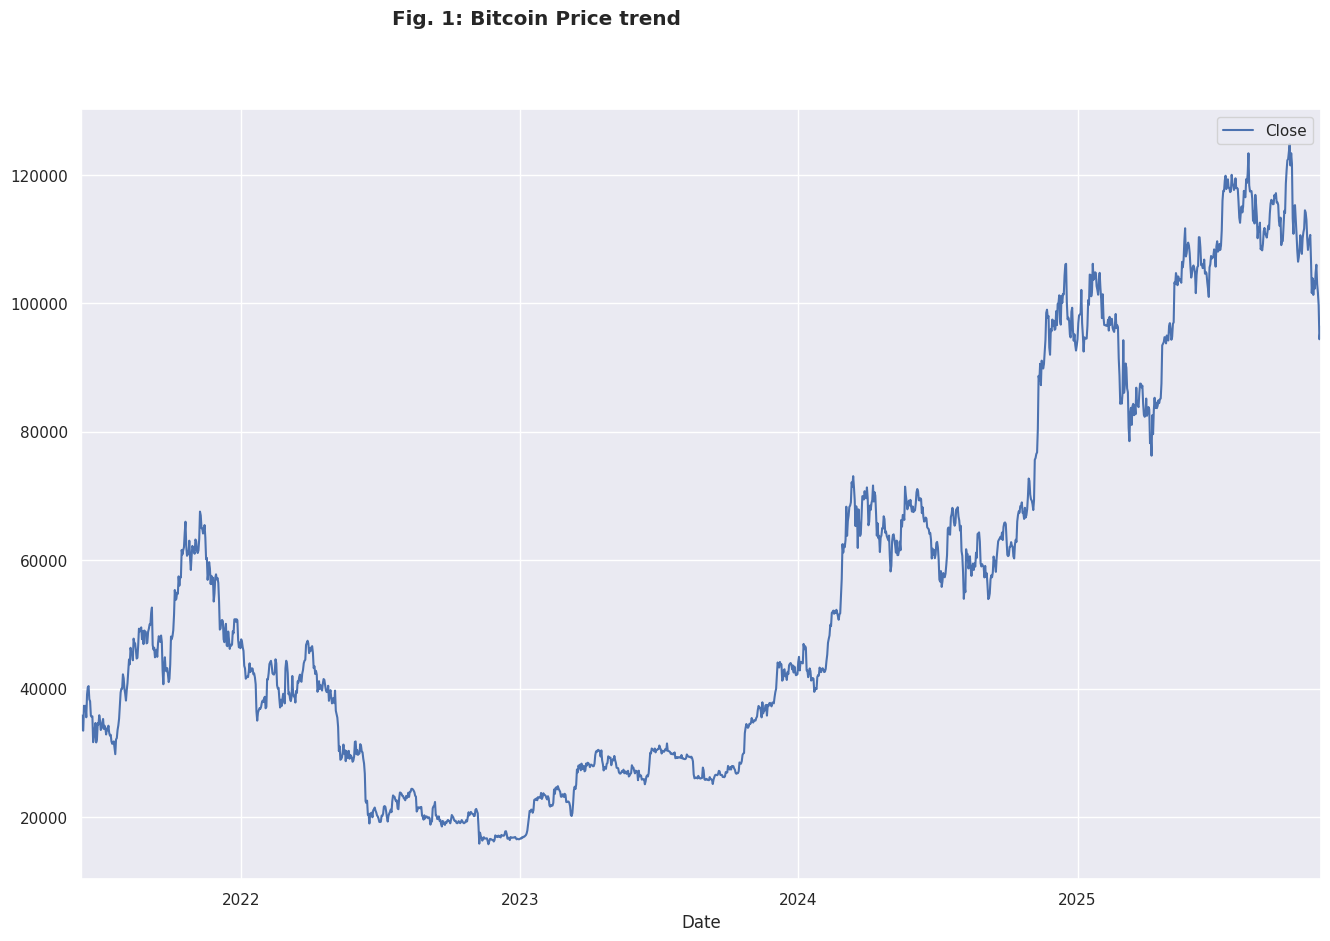

In [22]:
BTC_Data[["Close"]].plot(figsize=(16, 10),grid=True)
plt.suptitle(
    "Fig. 1: Bitcoin Price trend", fontweight="bold", horizontalalignment="right"
)
plt.show()

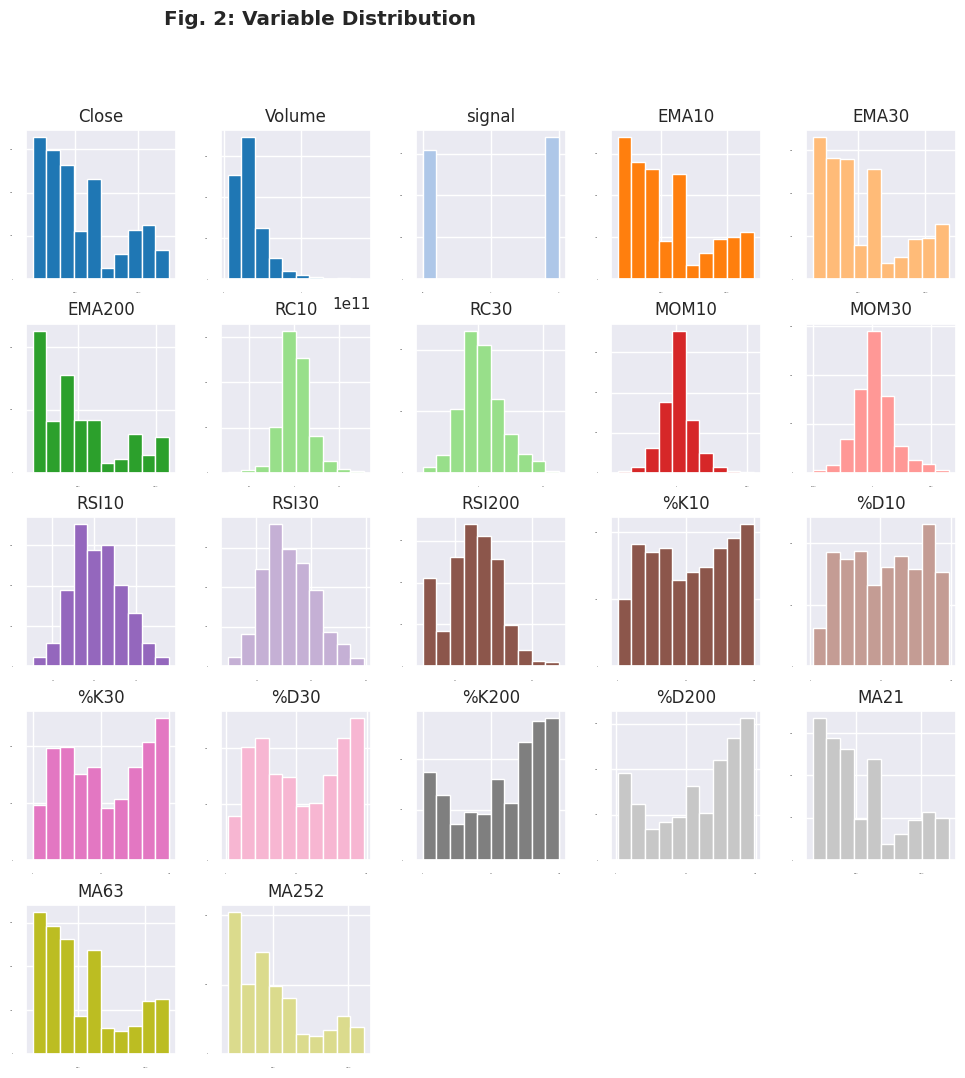

In [23]:
# create histograms
axes = BTC_Data.hist(
    sharex=False,
    sharey=False,
    xlabelsize=1,
    ylabelsize=1,
    figsize=(12, 12)
)
# flatten axes array (pandas returns a grid)
axes = axes.flatten()

# generate dynamic colors
colors = plt.cm.tab20(np.linspace(0, 1, len(axes)))

# apply a different color to each subplot
for ax, c in zip(axes, colors):
    for patch in ax.patches:
        patch.set_facecolor(c)

plt.suptitle(
    "Fig. 2: Variable Distribution",
    fontweight="bold",
    horizontalalignment="right"
)

plt.show()


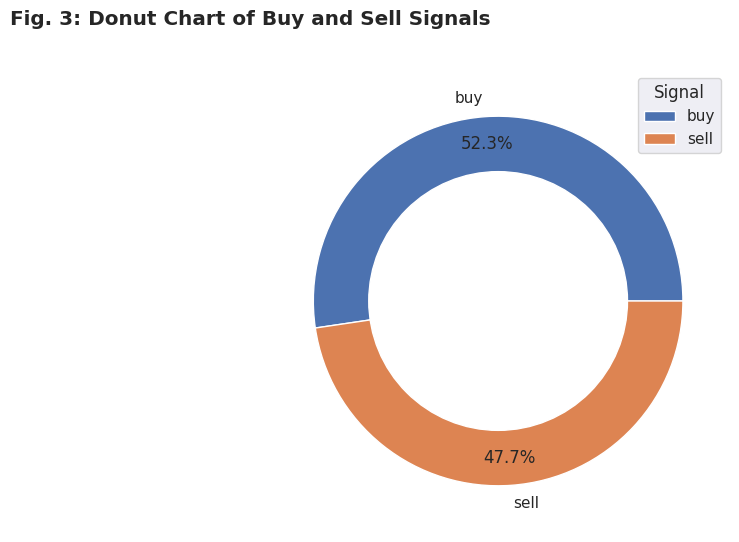

In [24]:
signal_map = {0: "sell", 1: "buy"}
counts = BTC_Data["signal"].map(signal_map).value_counts()

fig, ax = plt.subplots(figsize=(6, 6))
wedges, _, _ = ax.pie(counts, labels=counts.index, autopct="%1.1f%%", pctdistance=0.85)
ax.add_artist(plt.Circle((0, 0), 0.70, color="white"))

plt.legend(wedges, counts.index, title="Signal", loc="best")  # ← added key
plt.suptitle("Fig. 3: Donut Chart of Buy and Sell Signals", fontweight="bold", ha="right")
plt.show()


In [25]:
signal_map = {0: "sell", 1: "buy"}
BTC_Data["signal"].map(signal_map).value_counts().sort_values(ascending=False)


,count
signal,
buy,851
sell,775


# **Relationship between  variables using a correlation matrix of the returns.**

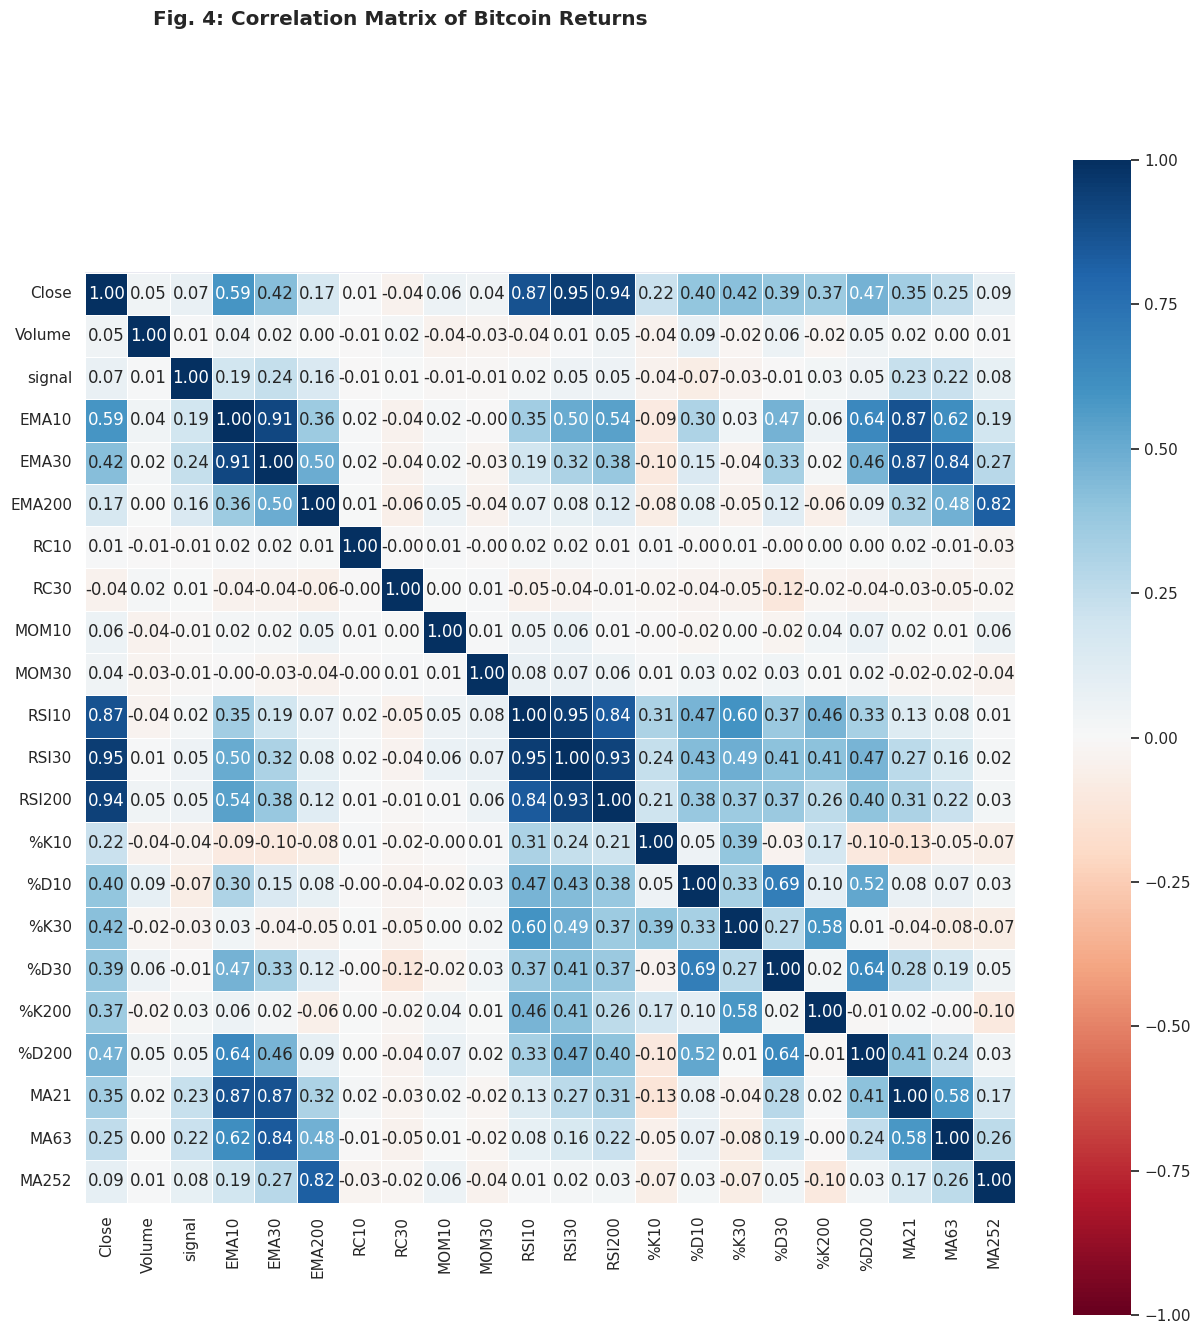

In [26]:
# Compute daily returns (percentage change)
BTC_returns = BTC_Data.pct_change().dropna()   # or log returns: np.log(BTC_Data / BTC_Data.shift(1))

# Correlation matrix
corr = BTC_returns.corr()

# Plot heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu", vmin=-1, vmax=1, square=True, linewidths=0.5)

plt.suptitle("Fig. 4: Correlation Matrix of Bitcoin Returns", fontweight="bold", horizontalalignment="right")
plt.show()


In [27]:
def time_series_split(target, features, test_period=6, val_period=None):
    """
    Splits features and target into train/test (and optional validation) sets for time series.

    Parameters:
    -----------
    target : pd.Series
        Target variable with Date as index (single or multi-index)
    features : pd.DataFrame
        Feature matrix with same index as target
    test_period : int
        Number of last rows (dates) for test set
    val_period : int or None
        Number of rows before test to use as validation. If None, no validation set is created.

    Returns:
    --------
    dict of pd.Series/pd.DataFrame: {'X_train','y_train','X_val','y_val','X_test','y_test'}
    """
    # Merge features and target
    df = features.join(target.rename("target")).sort_index(level="Date")

    if val_period:
        train = df.iloc[:-(test_period + val_period)]
        val = df.iloc[-(test_period + val_period):-test_period]
    else:
        train = df.iloc[:-test_period]
        val = None

    test = df.iloc[-test_period:]

    X_train, y_train = train.drop("target", axis=1), train["target"]
    X_val, y_val = (val.drop("target", axis=1), val["target"]) if val_period else (None, None)
    X_test, y_test = test.drop("target", axis=1), test["target"]

    return {
        "X_train": X_train, "y_train": y_train,
        "X_val": X_val, "y_val": y_val,
        "X_test": X_test, "y_test": y_test
    }


In [28]:
subset_validation = BTC_Data[1301:]

In [29]:
subset_validation.shape

(325, 22)

In [30]:
# split out validation dataset for the end
subset_dataset = BTC_Data[:1300]
y = subset_dataset["signal"]
X = subset_dataset.loc[:, BTC_Data.columns != "signal"]
X.index = pd.to_datetime(X.index)
validation_size = 0.2
seed = 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=validation_size, random_state=1
)

In [31]:
subset_dataset.shape

(1300, 22)

In [32]:
#creating a validation dataset that consists of the remaining data we did not pick in the subset dataset.
#This validation dataset will only be used in backtesting our models.

subset_validation = BTC_Data[1300:]
y_validation = subset_validation["signal"]
X_validation = subset_validation.loc[:, BTC_Data.columns != "signal"]

In [33]:
X_validation.shape

(326, 21)

# **Baseline Classifier**

***evaluation metrics***.

In [34]:
# test options for classification
num_folds = 10
seed = 42
scoring = "accuracy"
metrics = {
    "balanced_accuracy": "Accuracy",
    "roc_auc": "AUC",
    "neg_log_loss": "Log Loss",
    "f1_weighted": "F1",
    "precision_weighted": "Precision",
    "recall_weighted": "Recall",
}

***cross-validation function for evaluating different algorithms.***

In [35]:
def run_cv(clf, X, y, metrics=metrics, cv=10, n_jobs=-1):
    from time import time

    start = time()
    scores = cross_validate(
        estimator=clf,
        X=X,
        y=y,
        scoring=list(metrics.keys()),
        cv=cv,
        return_train_score=True,
        n_jobs=n_jobs,
        verbose=1,
    )
    duration = time() - start
    return scores, duration


***Function for manipulating the cross-validation output and plot them***

In [36]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split("_", 1)) for m in scores.keys()], names=["Dataset", "Metric"]
    )
    data = np.array(list(scores.values())).T
    df = pd.DataFrame(data=data, columns=columns).iloc[:, 2:]
    results = pd.melt(df, value_name="Value")
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

***Plot function that will display the metrics of our models as box plots***

In [37]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(
        x="Dataset",
        y="Value",
        hue="Dataset",
        col="Metric",
        data=df,
        col_order=m,
        order=["Train", "Test"],
        kind="box",
        col_wrap=3,
        sharey=False,
        height=4,
        aspect=1.2,
    )
    df = df.groupby(["Metric", "Dataset"]).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(
            0.05,
            0.85,
            s,
            fontsize=10,
            transform=ax.transAxes,
            bbox=dict(facecolor="white", edgecolor="grey", boxstyle="round,pad=0.5"),
        )
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    if fname:
        g.savefig(fname, dpi=300);

*defining the dummy classifier*

In [38]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
algo = "dummy_clf"

In [39]:
fname = f"{algo}.joblib"
dummy_cv_result, run_time_algo = run_cv(dummy_clf, X, y)

joblib.dump(dummy_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished


['dummy_clf.joblib']

In [40]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.498420,0.513888
Accuracy,0.498420,0.513888
F1,0.498849,0.514150
Log Loss,-18.049553,-17.513519
Precision,0.498796,0.514219
Recall,0.499231,0.514103


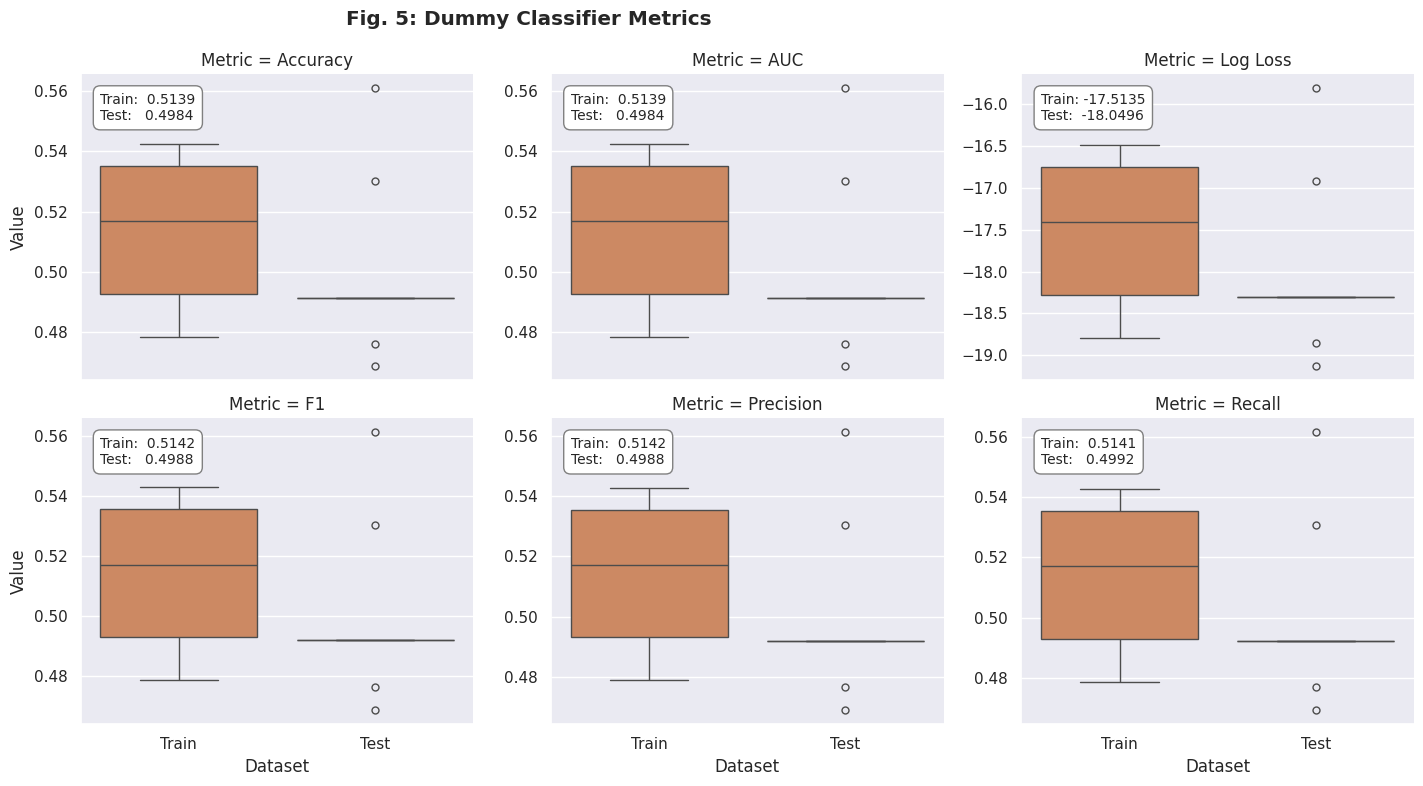

In [41]:
plot_result(dummy_result, model="Dummy Classifier")
plt.suptitle(
    "Fig. 5: Dummy Classifier Metrics", fontweight="bold", horizontalalignment="right"
)
plt.show()

# **Defining the Classification Algorithms**

In [42]:
# spot check the algorithms
models = []
models.append(("LR", LogisticRegression(n_jobs=-1)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# Neural Network
models.append(("NN", MLPClassifier()))
# Ensemble Models
# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs=-1)))

***Evaluating these models' performance using kFold cross-validation***

In [43]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.852885 (0.030422)
LDA: 0.932692 (0.024325)
KNN: 0.532692 (0.039924)
CART: 0.905769 (0.033530)
NB: 0.525962 (0.037004)
NN: 0.504808 (0.056437)
AB: 0.925962 (0.018269)
GBM: 0.940385 (0.010356)
RF: 0.942308 (0.020169)


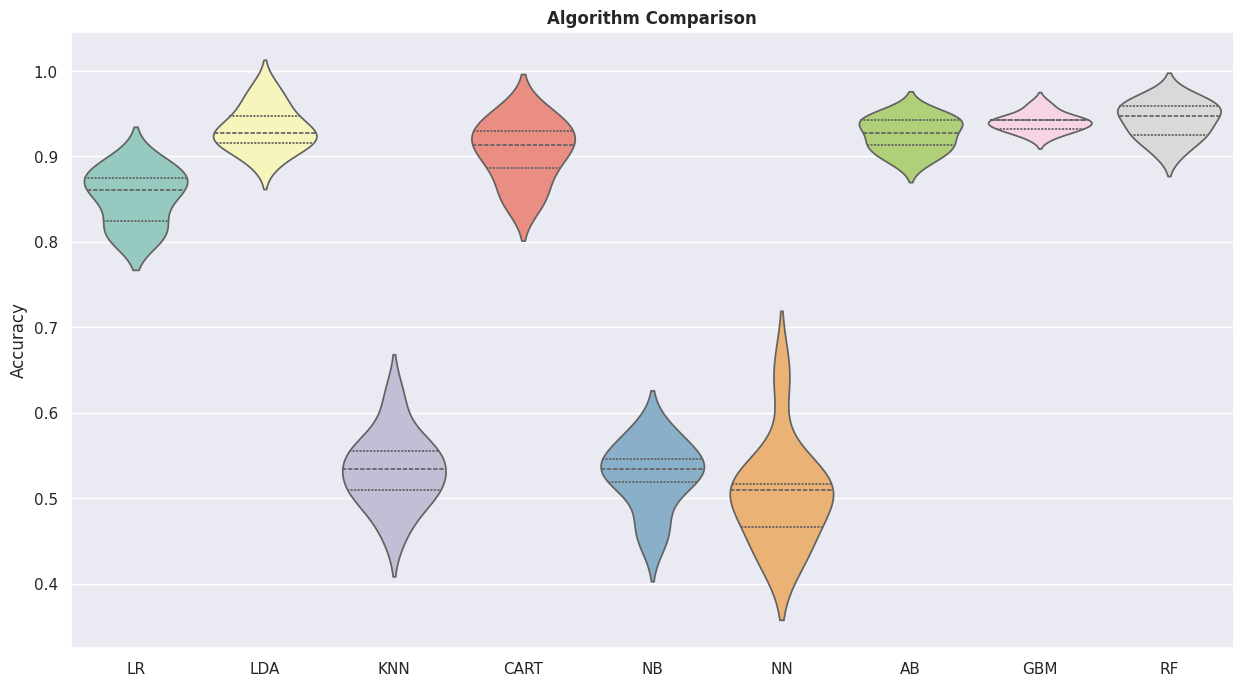

In [44]:
plt.figure(figsize=(15,8))
sns.violinplot(data=results, palette="Set3", inner="quartile")
plt.xticks(ticks=range(len(names)), labels=names)
plt.title("Algorithm Comparison", fontweight="bold", loc="center")
plt.ylabel("Accuracy")
plt.show()


# **Hyperparameter Tuning**

*Since random forest was our best performer, we tune its hyperparameters to improve the performance even further.*

# **Gridsearch**

In [45]:
# Grid Search: Random Forest Classifier
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20, 80]
max_depth = [5, 10]
criterion = ["gini", "entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.944231 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#8 0.920192 (0.025092) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#7 0.924038 (0.019446) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.937500 (0.015050) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#3 0.938462 (0.020261) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#6 0.928846 (0.016204) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.929808 (0.021522) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#2 0.943269 (0.018965) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.944231 (0.018142) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [46]:
# prepare model
model = RandomForestClassifier(
    criterion="gini", n_estimators=80, max_depth=10, n_jobs=-1
)  # `rbf` is default kernel

In [47]:
algo_forest = "random_forest"

In [48]:
fname = f"{algo_forest}.joblib"

random_forest_cv_result, run_time_algo_forest = run_cv(model, X,y)
joblib.dump(random_forest_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


['random_forest.joblib']

In [49]:
rf_result = stack_results(random_forest_cv_result)
rf_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.876205,1.000000
Accuracy,0.792089,0.999417
F1,0.785270,0.999402
Log Loss,-0.477827,-0.045572
Precision,0.816034,0.999403
Recall,0.793077,0.999402


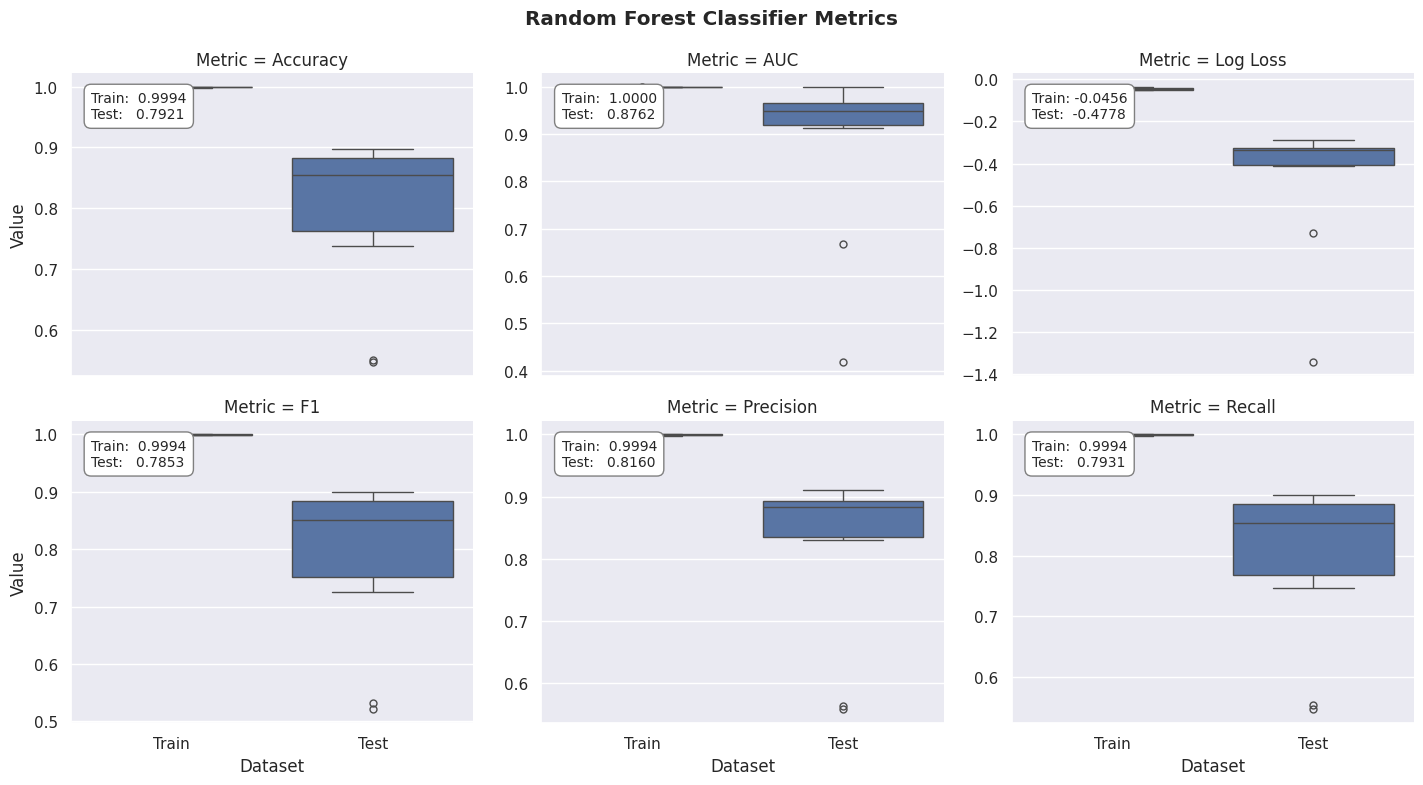

In [50]:
plot_result(rf_result, model="Random Forest Classifier")
plt.suptitle(
    "Random Forest Classifier Metrics",
    fontweight="bold",
    horizontalalignment="center",
)
plt.show()

# **Comparison of the random forest classifier and the dummy classifier.**

In [51]:
results = {
    "Baseline": dummy_result,
    "Random Forest": rf_result,
}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat(
        [
            df,
            result.groupby(["Metric", "Dataset"])
            .Value.mean()
            .unstack()["Test"]
            .to_frame(model),
        ],
        axis=1,
    )

df.T.sort_values("AUC", ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
Random Forest,0.876205,0.792089,0.785270,-0.477827,0.816034,0.793077
Baseline,0.498420,0.498420,0.498849,-18.049553,0.498796,0.499231


# ***Now Training the RandomForestClassifier***

In [52]:
model = RandomForestClassifier(
    criterion="gini", n_estimators=80, max_depth=10, n_jobs=-1
)
model.fit(X_train, y_train)
# estimate accuracy on validation set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9538461538461539
[[135   5]
 [  7 113]]
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       140
         1.0       0.96      0.94      0.95       120

    accuracy                           0.95       260
   macro avg       0.95      0.95      0.95       260
weighted avg       0.95      0.95      0.95       260



***Evaluate the model's performance, with the confusion matrix***

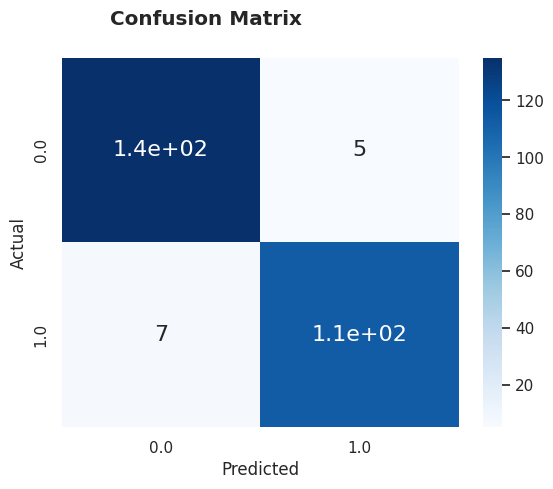

In [53]:
df_cm = pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=np.unique(y_test),
    index=np.unique(y_test),
)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font sizes
plt.suptitle(" Confusion Matrix", fontweight="bold", horizontalalignment="right")
plt.show()

***variables with more predictive powers***

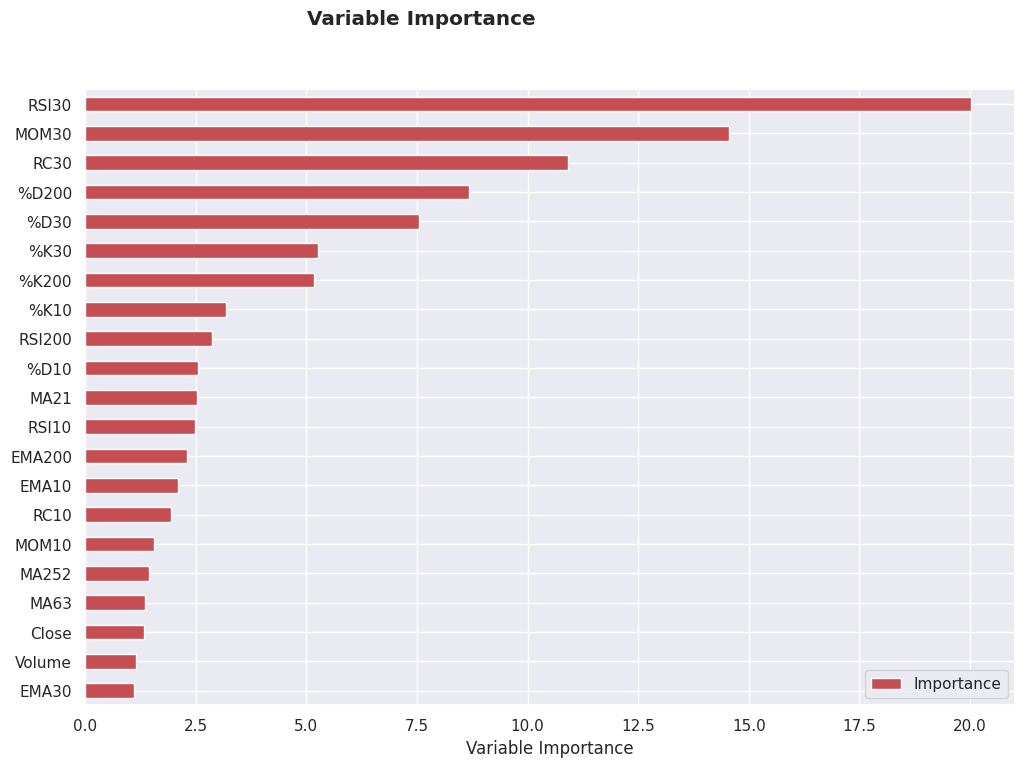

In [54]:
Importance = pd.DataFrame(
    {"Importance": model.feature_importances_ * 100}, index=X.columns
)
Importance.sort_values("Importance", axis=0, ascending=True).plot(
    kind="barh", color="r", figsize=(12, 8)
)
plt.xlabel("Variable Importance")
plt.suptitle(
    "Variable Importance", fontweight="bold", horizontalalignment="right"
)
plt.show()

# **Backtesting**

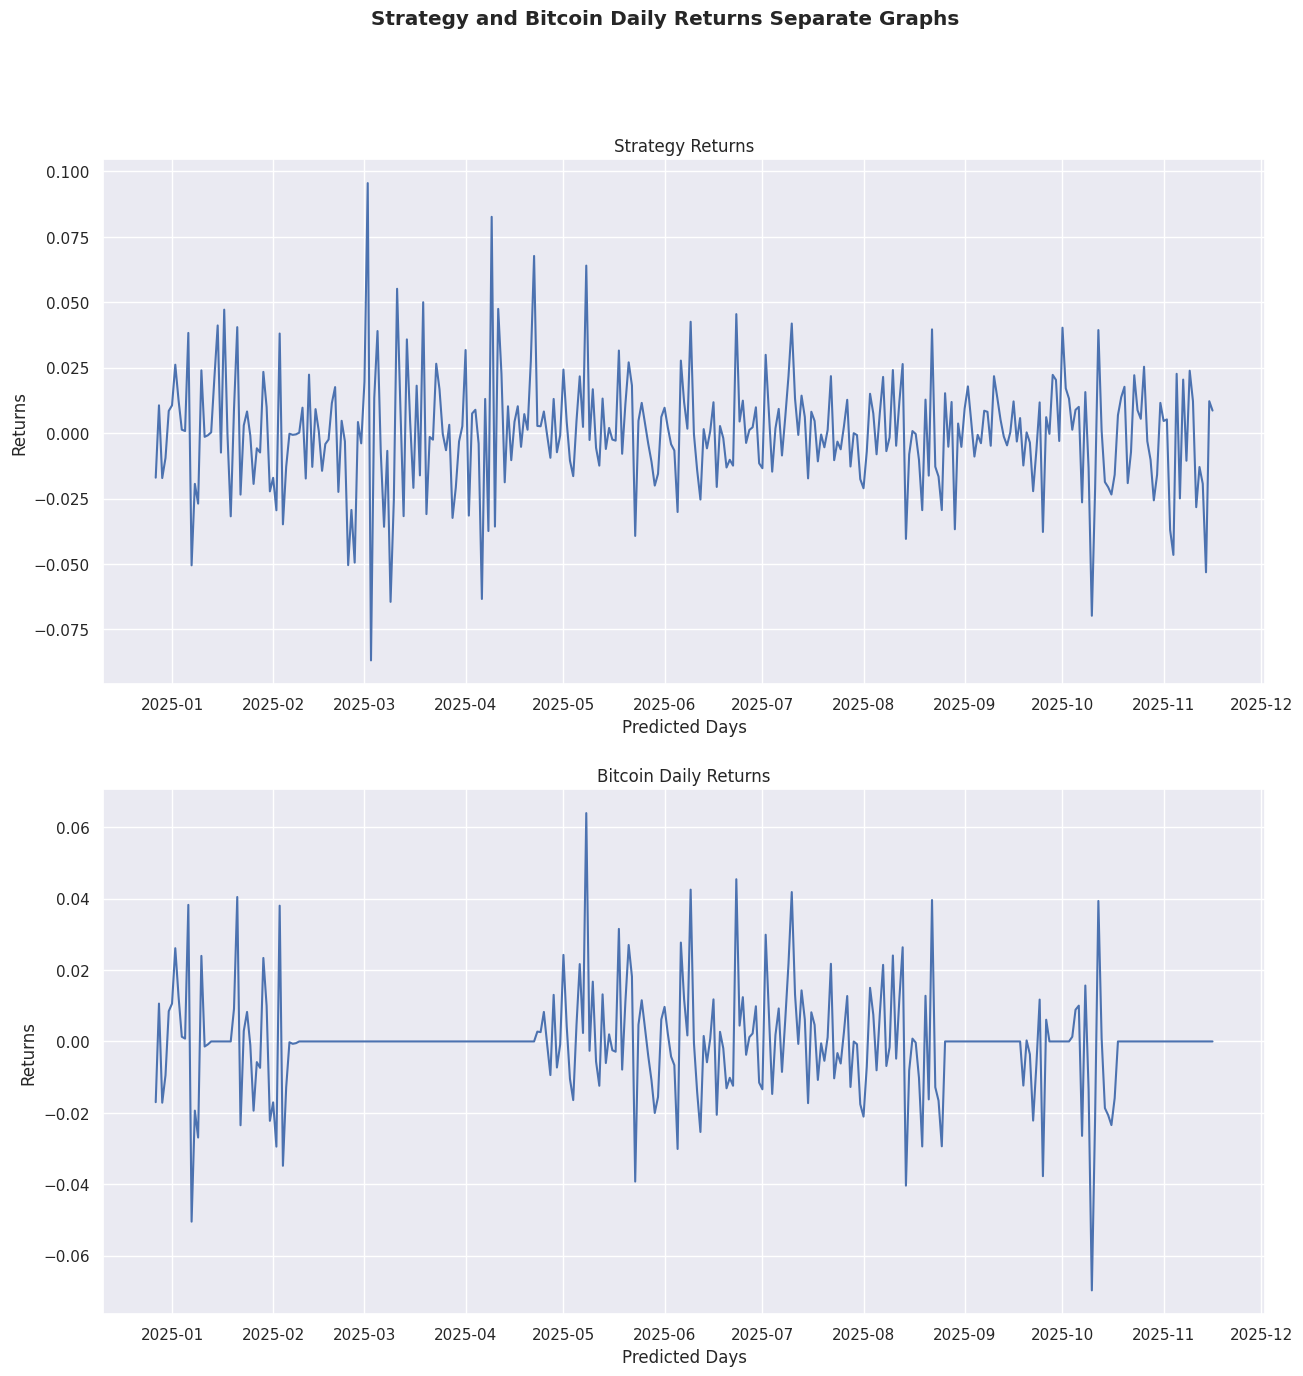

In [55]:
# Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
# of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
validation_prediction = model.predict(X_validation)
backtestdata["signal_pred"] = validation_prediction
backtestdata["signal_actual"] = y_validation
backtestdata["Market Returns"] = X_validation["Close"].pct_change()
backtestdata["Actual Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_actual"
].shift(1)
backtestdata["Strategy Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_pred"
].shift(1)
# backtestdata=backtestdata.reset_index()
backtestdata.head()

fig, axs = plt.subplots(2, figsize=(15, 15))
fig.suptitle("Vertically stacked subplots")
axs[0].plot(backtestdata["Strategy Returns"])
axs[0].set_title("Strategy Returns")
axs[1].plot(backtestdata["Actual Returns"])
axs[1].set_title("Bitcoin Daily Returns")

for ax in axs.flat:
    ax.set(xlabel="Predicted Days", ylabel="Returns")

# `backtestdata`[['Strategy Returns','Actual Returns']].plot()
# `plt.title`('Cumulative Strategy Returns vs Cumulative Actual Returns')
plt.suptitle(
    "Strategy and Bitcoin Daily Returns Separate Graphs",
    fontweight="bold",
    horizontalalignment="center",
)
plt.show()

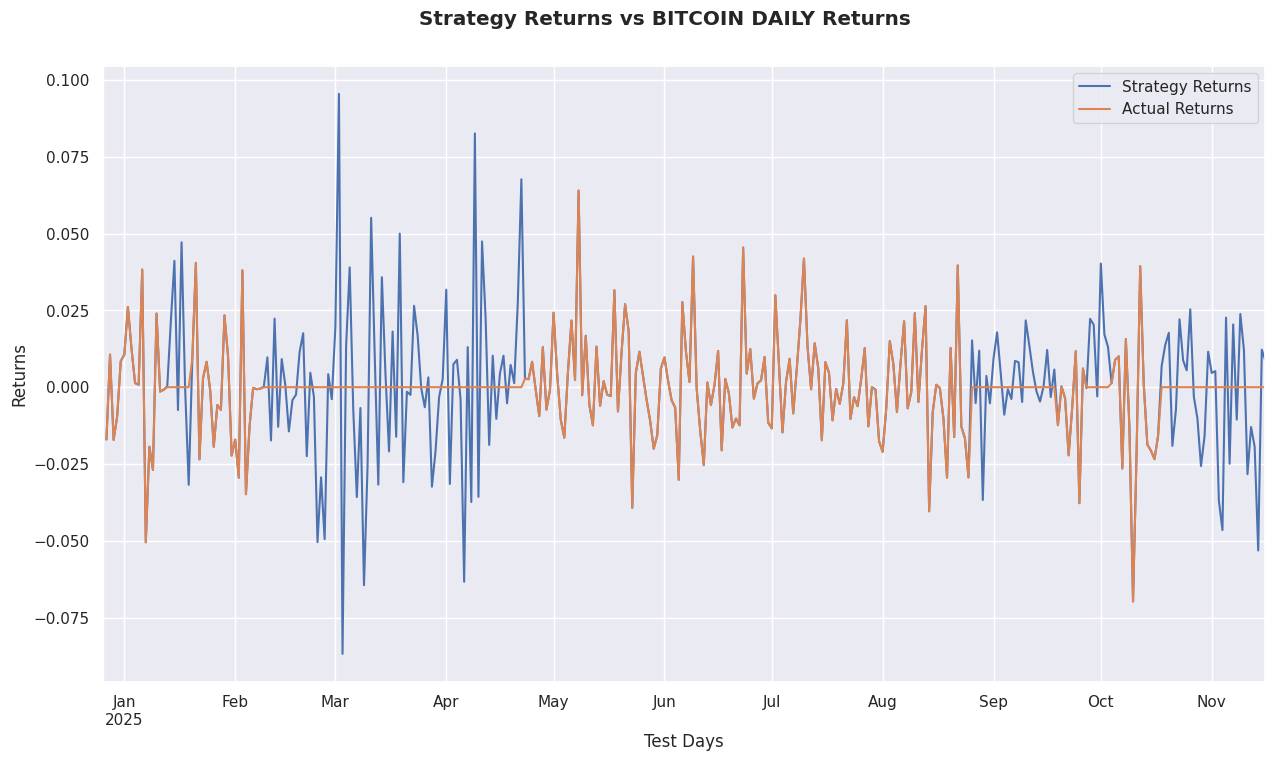

In [56]:
# Plot both series on the same figure
backtestdata[["Strategy Returns", "Actual Returns"]].plot(figsize=(15, 8))

# Figure-level title (centered)
plt.suptitle(
    "Strategy Returns vs BITCOIN DAILY Returns",
    fontweight="bold",
    x=0.5,
    y=0.95
)

# Axis labels
plt.xlabel("Test Days")
plt.ylabel("Returns")

plt.show()


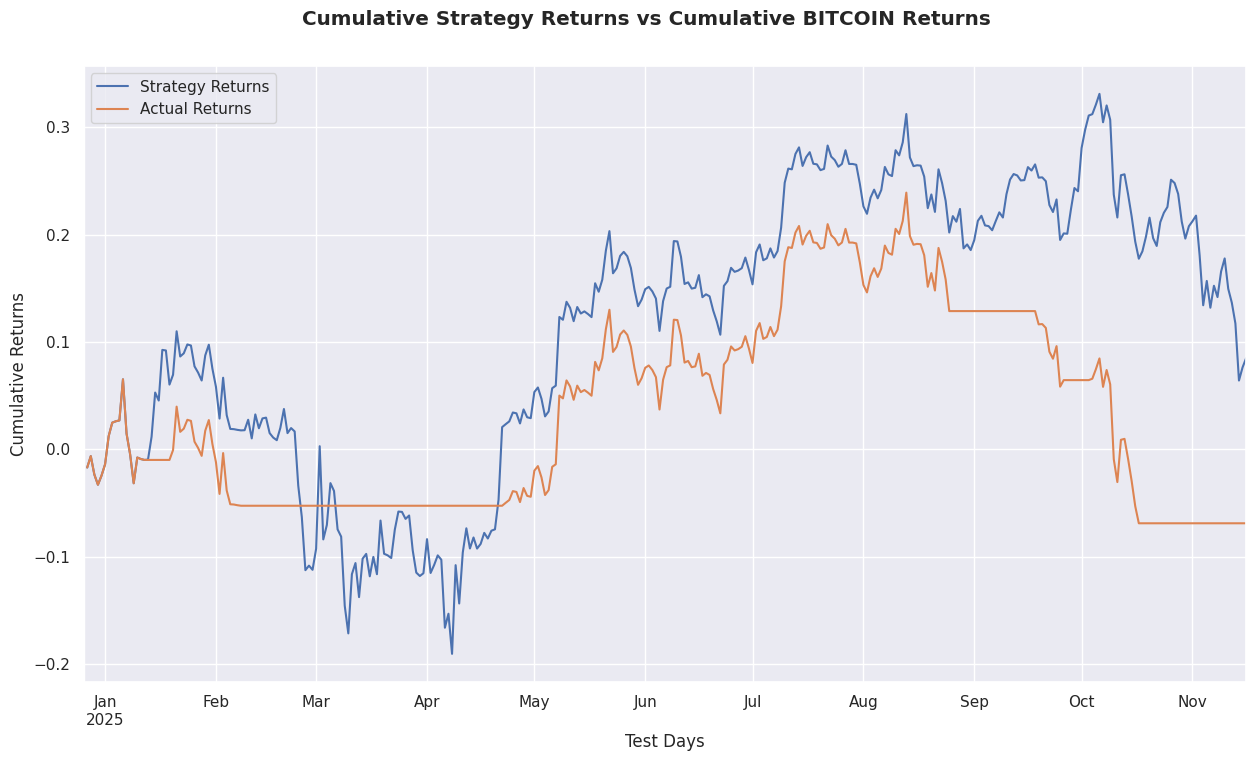

In [57]:
#Cumulative returns for both strategy returns and the Bitcoin returns to compare how we expect to perform in the near future if we applied our trading model.
import matplotlib.pyplot as plt

backtestdata[["Strategy Returns", "Actual Returns"]].cumsum().plot(figsize=(15, 8))
plt.xlabel("Test Days")
plt.ylabel("Cumulative Returns")
plt.suptitle(
    "Cumulative Strategy Returns vs Cumulative BITCOIN Returns",
    fontweight="bold",
    x=0.5,
    y=0.95
)
plt.show()
